# Практическое задание: Подключение к Postgres из Python - DB-API

Так как хранить параметры учётной записи в коде небезопасно, создадим хранилище.

Я оставил код для создания хранилища, чтобы его можно было проверить. Если Вы не захотите создавать хранилище, можно взять значения, которые я в него сохранял, и внести в переменные user, password, host, port

In [11]:
!pip install keyring -q

In [25]:
import keyring

# Установка секретов
keyring.set_password("sql_course_database", "user", "student")
keyring.set_password("sql_course_database", "password", "6ecf4d61")
keyring.set_password("sql_course_database", "host", "92.63.70.133")
keyring.set_password("sql_course_database", "port", "5432")

In [26]:
import keyring

# Получение секретов
user = keyring.get_password("sql_course_database", "user")
password = keyring.get_password("sql_course_database", "password")
host = keyring.get_password("sql_course_database", "host")
port = keyring.get_password("sql_course_database", "port")

## 1. Сегментация пользователей мобильной игры по географии - 1 балл
Напишите python-запрос в jupyter-ноутбуке, в котором с помощью библиотеки psycopg2 и SQL рассчитайте количество уникальных пользователей по странам используя данные из таблицы mobile_game_raw.all_events из базы project. Результат выведите в виде столбчатой диаграммы используя вашу любимую библиотеку для визуализации. 

C:\Users\pahan\AppData\Local\Temp\ipykernel_33840\3757959221.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


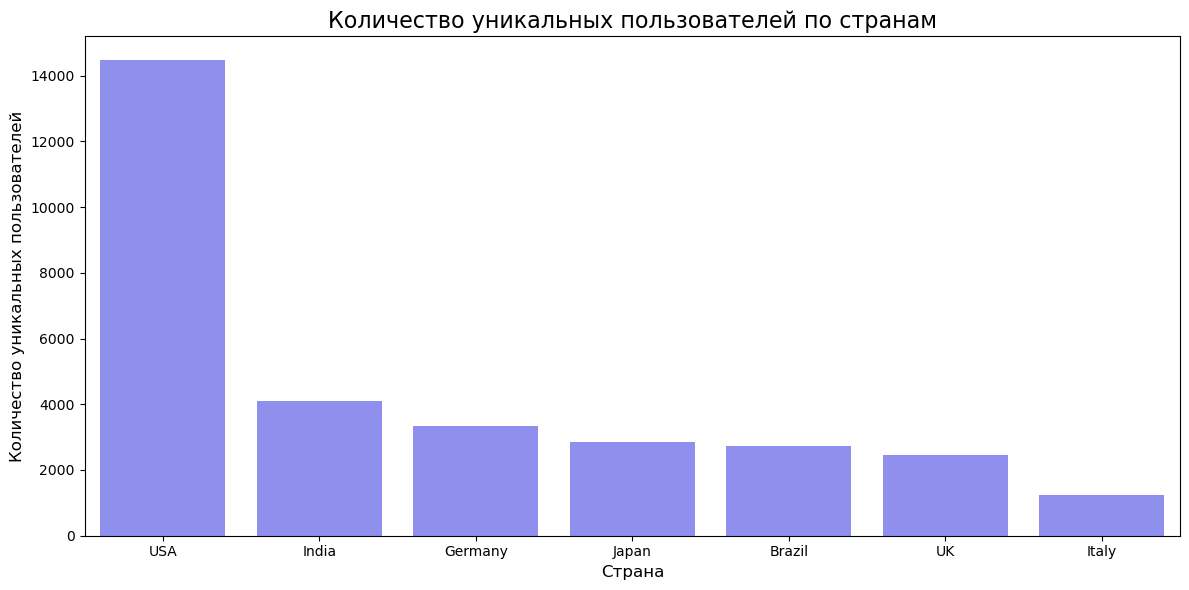

In [27]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = psycopg2.connect(
    dbname="project",
    user=user,
    password=password,
    host=host,
    port=port
)

query = """
select 
    country, 
    count(distinct user_id) as unique_users
from mobile_game_raw.all_events
group by country
order by unique_users desc
"""

df = pd.read_sql(query, conn)

conn.close()

plt.figure(figsize=(12, 6))
sns.barplot(x="country", y="unique_users", data=df, color="blue", alpha=0.5)
plt.title("Количество уникальных пользователей по странам", fontsize=16)
plt.ylabel("Количество уникальных пользователей", fontsize=12)
plt.xlabel("Страна", fontsize=12)
plt.tight_layout()
plt.show()

## 2. Построчное чтение данных - 3 балла
1) Напишите python-запрос в jupyter-ноутбуке: 
Напишите запрос для получения последних 10 транзакций из таблицы coffe_shop.sales, отсортировав их по transaction_date и transaction_time в порядке убывания.
2) Используя метод fetchone(), извлекайте по одной записи в цикле и выполняйте следующие преобразования для каждой записи
    1) Преобразуйте дату transaction_date и время transaction_time в формат YYYY-MM-DD HH:MM:SS.
    2) Посчитайте общую сумму для транзакции, умножив quantity на unit_price. Округлите результат до двух знаков после запятой.
    3) Создайте категорию для транзакции:
        - Если сумма меньше 3 — категория “Low”.
        - От 3 до 5 — категория “Medium”.
        - Более 5 — категория “High”.
    4) Преобразуйте значение product_name в верхний регистр. 
    5) После преобразований выведите текстовый отчет в следующем формате: Transaction ID: {transaction_id}, Date: {formatted_date}, Product: {product_name_upper}, Total Cost: {total_cost}, Category: {price_category}

In [29]:
import psycopg2
from datetime import datetime

conn = psycopg2.connect(
    dbname="postgres",
    user=user,
    password=password,
    host=host,
    port=port
)

cursor = conn.cursor()
query = """
select 
    transaction_id
    , transaction_date
    , transaction_time
    , quantity
    , unit_price
    , product_name
from coffe_shop.sales
order by transaction_date DESC, transaction_time DESC
limit 10;
"""

cursor.execute(query)

for _ in range(10):
    row = cursor.fetchone()
    if row is None:
        break

    transaction_id, transaction_date, transaction_time, quantity, unit_price, product_name = row

    transaction_datetime = datetime.strptime(f"{transaction_date} {transaction_time}", "%Y-%m-%d %H:%M:%S")
    formatted_date = transaction_datetime.strftime("%Y-%m-%d %H:%M:%S")

    total_cost = round(quantity * unit_price, 2)

    if total_cost < 3:
        price_category = "Low"
    elif 3 <= total_cost <= 5:
        price_category = "Medium"
    else:
        price_category = "High"

    product_name_upper = product_name.upper()

    print(f"Transaction ID: {transaction_id}, Date: {formatted_date}, Product: {product_name_upper}, Total Cost: {total_cost}, Category: {price_category}")

cursor.close()
conn.close()

Transaction ID: 49654, Date: 2019-04-29 19:59:28, Product: COLUMBIAN MEDIUM ROAST LG, Total Cost: 3.0, Category: Medium
Transaction ID: 48656, Date: 2019-04-29 19:57:55, Product: EARL GREY LG, Total Cost: 6.0, Category: High
Transaction ID: 48960, Date: 2019-04-29 19:57:52, Product: TRADITIONAL BLEND CHAI RG, Total Cost: 5.0, Category: Medium
Transaction ID: 49822, Date: 2019-04-29 19:57:00, Product: OUR OLD TIME DINER BLEND SM, Total Cost: 2.0, Category: Low
Transaction ID: 49823, Date: 2019-04-29 19:57:00, Product: OATMEAL SCONE, Total Cost: 3.0, Category: Medium
Transaction ID: 49625, Date: 2019-04-29 19:55:51, Product: SERENITY GREEN TEA LG, Total Cost: 6.0, Category: High
Transaction ID: 48717, Date: 2019-04-29 19:54:46, Product: OUR OLD TIME DINER BLEND SM, Total Cost: 4.0, Category: Medium
Transaction ID: 48861, Date: 2019-04-29 19:53:41, Product: BRAZILIAN RG, Total Cost: 6.0, Category: High
Transaction ID: 49700, Date: 2019-04-29 19:53:03, Product: TRADITIONAL BLEND CHAI LG, T

## 3. Анализ выручки по странам и продуктам с помесячной детализацией - 3 балла
Постройте тепловую карту выручки по связке “страна + продукт” по месяцам по данным из базы project из таблицы mobile_game_raw.all_events. 

Цель - понять распределение выручки по странам и продуктам и выявить ключевые источники дохода продукта. 

C:\Users\pahan\AppData\Local\Temp\ipykernel_33840\2681219804.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


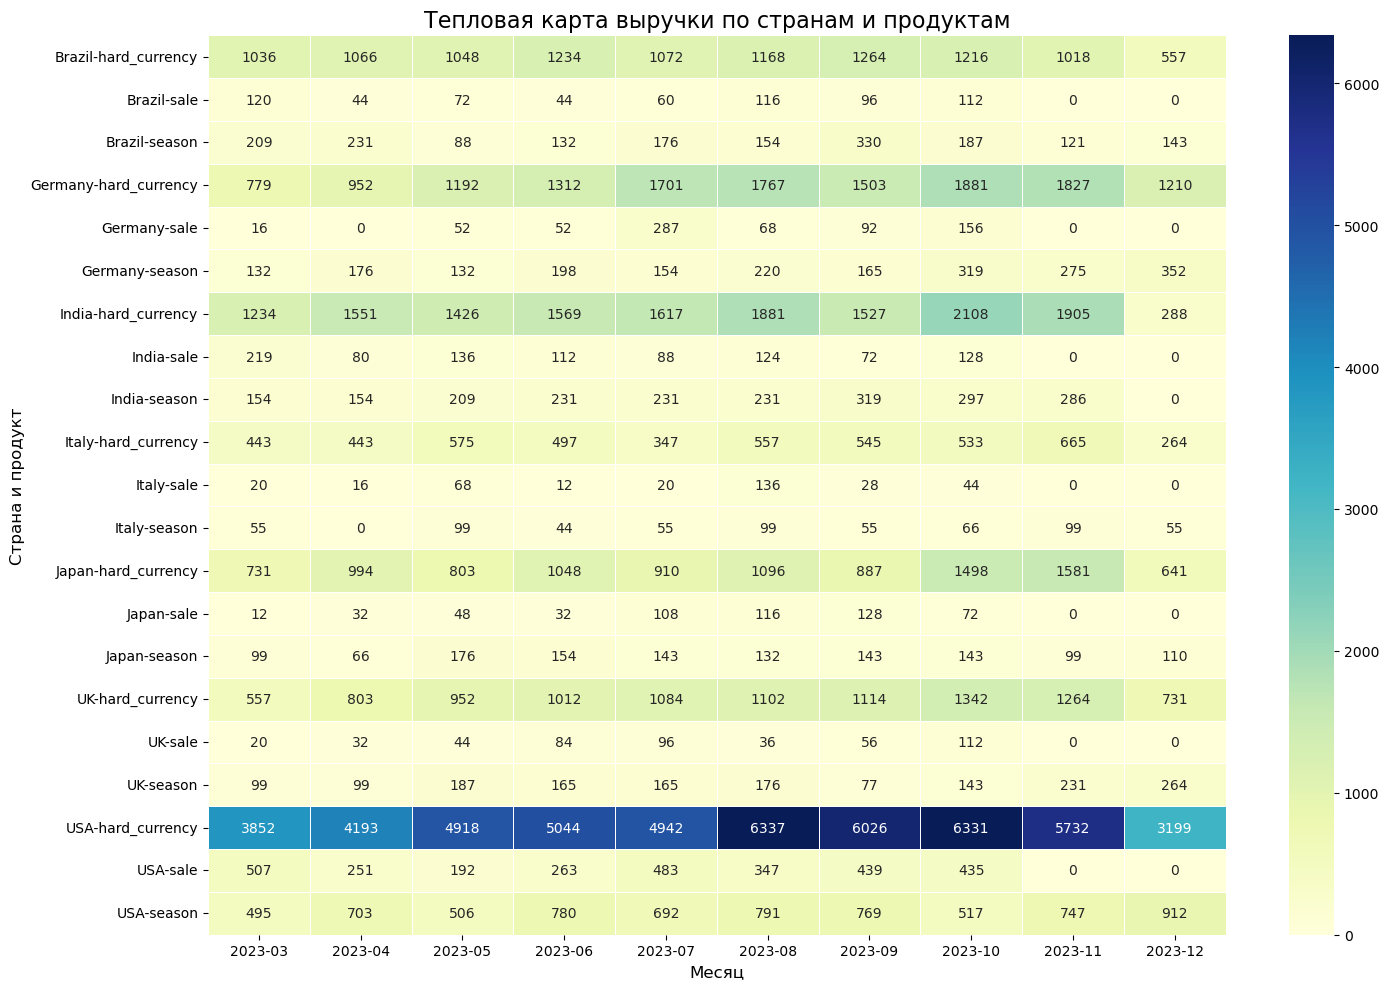

In [46]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = psycopg2.connect(
    dbname="project",
    user=user,
    password=password,
    host=host,
    port=port
)

query = """
with revenue_data as (
    select
        date_trunc('month', event_time) as month
        , country
        , event_properties->'transaction'->>'product_name' as product
        , sum(cast(event_properties->'transaction'->>'revenue' as numeric)) as revenue
    from mobile_game_raw.all_events
    where event_name = 'transaction'
    group by 1,2,3
)
select
    month
    , country
    , product
    , revenue
from revenue_data
order by 1,2,3;
"""

df = pd.read_sql(query, conn)

conn.close()

df['month'] = pd.to_datetime(df['month']).dt.to_period('M')
pivot_table = df.pivot_table(index=['country', 'product'],
                             columns='month',
                             values='revenue',
                             fill_value=0)

plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=.5)
plt.title("Тепловая карта выручки по странам и продуктам", fontsize=16)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("Страна и продукт", fontsize=12)
plt.tight_layout()
plt.show()